## Real estate prices prediction & feature engineering

In [52]:
import pandas as pd
import numpy as np
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F

### All features

In [53]:
train_file_path = 'data/train.csv'
test_file_path = 'data/test.csv'

df = pd.read_csv(train_file_path)
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [54]:
target_feature = 'SalePrice'

df[target_feature].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

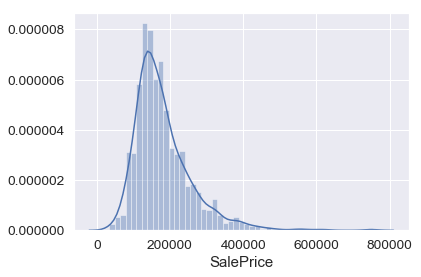

In [55]:
# Sale prices distribution
sns.distplot(df[target_feature])

### Features selection

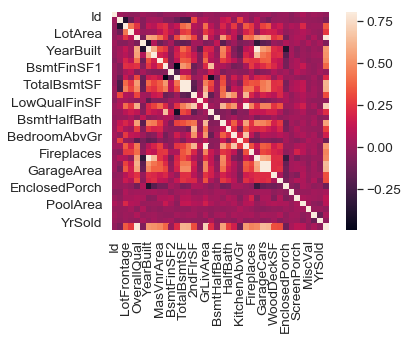

In [56]:
corr_mat = df.corr()
sns.heatmap(corr_mat, vmax=.8, square=True)

Take a closer look at features with the highest correlation:

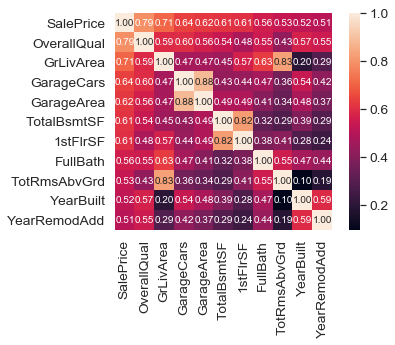

In [57]:
num_features = 11
cols = corr_mat.nlargest(num_features, target_feature)[target_feature].index
new_corr_mat = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
sns.heatmap(new_corr_mat, cbar=True, annot=True, square=True, fmt='.2f',
            annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)

### Missing data handling

In [58]:
num_missing_values = df.isnull().sum().sort_values(ascending=False)
percent_missing = ((df.isnull().sum() * 100) / df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([num_missing_values, percent_missing], axis=1, keys=['Num', '%'])
missing_data.head(20)

,Num,%
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageCond,81,5.547945
GarageType,81,5.547945
GarageYrBlt,81,5.547945
GarageFinish,81,5.547945


Dropping columns containing too many `NA` values 

In [59]:
df = df.drop(missing_data[missing_data['%'] > 1].index, axis=1)
# Missing values left
df.isnull().sum().max()

8

### Select categorical features

In [60]:
# Drop redundant columns
df = df.drop(['Id', 'Utilities'], axis=1)
# All features left
features = df.columns
features

Index(['MSSubClass', 'MSZoning', 'LotArea', 'Street', 'LotShape',
       'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath',
       'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageCars', 'GarageArea',
       'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition', 'SalePrice'],
      dtype='object')

In [64]:
cat_features = [
    "MSSubClass", "MSZoning", "Street", "LotShape", "YearBuilt", 'YearRemodAdd', 'RoofStyle',
    'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd',
    'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir',
    'Electrical', 'KitchenQual', 'Functional', 'PavedDrive', 'YrSold', 'SaleType', 'SaleCondition',
    'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood'
]

### Model

In [62]:
class FFNN(nn.Module):
    def __init__(self, emb_dims, num_cont_features, lin_layer_sizes,
                 output_size, emb_dropout, lin_layer_dropouts):
        super(FFNN, self).__init__()

        self.emb_layers = nn.ModuleList([nn.Embedding(x, y) for x, y in emb_dims])

        self.num_embs = sum([y for _, y in emb_dims])
        self.num_cont_features = num_cont_features

        head_lin_layer = nn.Linear(self.num_embs + self.num_cont_features,
                                   lin_layer_sizes[0])

        self.lin_layers = nn.ModuleList(
            [head_lin_layer] + [nn.Linear(lin_layer_sizes[i], lin_layer_sizes[i + 1])
                                for i in range(len(lin_layer_sizes) - 1)]
        )

        for lin_layer in self.lin_layers:
            nn.init.kaiming_normal_(lin_layer.weight.data)

        self.output_layer = nn.Linear(lin_layer_sizes[-1], output_size)

        nn.init.kaiming_normal_(self.output_layer.weight.data)

        # Batch Norm layers
        self.head_bn_layer = nn.BatchNorm1d(self.num_cont_features)
        self.tail_bn_layers = nn.ModuleList(
            [nn.BatchNorm1d(size) for size in lin_layer_sizes]
        )

        # Dropout layers
        self.emb_dropout_layer = nn.Dropout(emb_dropout)
        self.dropout_layer = nn.ModuleList(
            [nn.Dropout(size) for size in lin_layer_dropouts]
        )

    def forward(self, cont_data, cat_data):
        assert self.num_embs + self.num_cont_features > 0

        if self.num_embs != 0:
            x = [emb_layer(cat_data[:, i]) for i, emb_layer in enumerate(self.emb_layers)]
            x = torch.cat(x, 1)
            x = self.emb_dropout_layer(x)

        if self.num_cont_features != 0:
            norm_cont_data = self.head_bn_layer(cont_data)

            if self.num_embs != 0:
                x = torch.cat((x, norm_cont_data), dim=1)
            else:
                x = norm_cont_data

        for lin_layer, bn_layer, dropout_layer in \
                zip(self.lin_layers, self.tail_bn_layers, self.dropout_layer):
            x = F.relu(lin_layer(x))
            x = bn_layer(x)
            x = dropout_layer(x)

        x = self.output_layer(x)

        return x

### Evaluation

In [68]:
import os
from utils import TabularDataset, fix_missing
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader

save_dir = 'data/'
training_state_file = 'train_state_v2.pt'

num_epochs = 1000
batch_size = 512

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'Using device: {device}')

try:
    checkpoint = torch.load(os.path.join(save_dir, training_state_file))
except FileNotFoundError:
    checkpoint = None

cont_features = [feature for feature in features if feature not in cat_features + [target_feature]]

for feature in cont_features:
    fix_missing(df, df[feature], feature, {})

data = df.dropna(axis=0)

label_encoders = {}
for cat_col in cat_features:
    label_encoders[cat_col] = LabelEncoder()
    data[cat_col] = label_encoders[cat_col].fit_transform(data[cat_col])

dataset = TabularDataset(data, cat_cols=cat_features, output_col=target_feature)

data_loader = DataLoader(dataset, batch_size=batch_size,
                         shuffle=True, num_workers=4, pin_memory=True)

cat_dims = [int(data[col].nunique()) for col in cat_features]
emb_dims = [(x, min(50, (x + 1) // 2)) for x in cat_dims]

model = FFNN(emb_dims, num_cont_features=31, lin_layer_sizes=[500, 1000, 500],
             output_size=1, emb_dropout=.04, lin_layer_dropouts=[.001, .01, .01]).to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=.01)

epochs_done = 0

if checkpoint:
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    model.eval()
    epochs_done = checkpoint['epochs_done']

for epoch in range(num_epochs - epochs_done):

    running_loss = .0

    for y, cont_x, cat_x in data_loader:

        y = y.to(device)
        cat_x = cat_x.to(device)
        cont_x = cont_x.to(device)

        predictions = model(cont_x, cat_x)
        loss = torch.sqrt(loss_fn(predictions, y))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    if epoch % 100 == 0:
        torch.save({
            'epochs_done': epoch,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
        }, os.path.join(save_dir, training_state_file))

        print(f'Epoch {epoch + epochs_done}, running loss {running_loss}')


Using device: cuda
Epoch 0, running loss 591844.859375
Epoch 100, running loss 549337.84375
Epoch 200, running loss 418310.625
Epoch 300, running loss 245406.234375
Epoch 400, running loss 38183.9384765625
Epoch 500, running loss 16187.685546875
Epoch 600, running loss 17757.89306640625
Epoch 700, running loss 9811.412841796875
Epoch 800, running loss 11040.031982421875
Epoch 900, running loss 14562.631591796875
Done


c:\users\ilya oskin\desktop\dev\env\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
